_This project was developed independently as part of Code Institute’s Predictive Analytics Project. Any datasets or templates used are openly provided by the course or via public sources like Kaggle. All commentary and code logic are my own._

# Notebook 02: Data Cleaning


## Objectives:
- Identify and handle missing values.
- Remove duplicates and inconsistencies.
- Standardize formatting and data types.
- Split the cleaned dataset.
- Save the cleaned datasets.
- Document the cleaning process.

## Additional Observations
- This notebook follows the Data Preparation stage of the CRISP-DM approach.
- Decisions for cleaning (such as imputation techniques and handling outliers) are based on subject expertise and data properties.
- The feature engineering notebook will cover outlier detection and management.
- In later notebooks, the cleaned and divided datasets are prepared for activities like feature engineering, exploratory data analysis, and model training.

## Change Working Directory
- Since it is expected that you would keep the notebooks in a subfolder, you will need to switch the working directory when you run the notebook in the editor.
- The working directory must be changed from its current folder to its parent folder.
- We wish to change the current directory's parent to the new current directory.
- Verify the updated current directory.

In [1]:
import os
# Smart Working Directory Setup
project_root = '/workspaces/heritage_housing'
if os.getcwd() != project_root:
    try:
        os.chdir(project_root)
        print(f"[INFO] Changed working directory to project root: {os.getcwd()}")
    except FileNotFoundError:
        raise FileNotFoundError(f"[ERROR] Project root '{project_root}' not found!")

[INFO] Changed working directory to project root: /workspaces/heritage_housing


## Import Packages & Set Environment Variables
- First, we need to import the numpy and pandas packages, and set the environment variables by running the following:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load Collected Data
- Now that we have imported the required packages and environment variables set, we need to load the data that was previously downloaded (refer to the Data Collection notebook).

In [3]:
# Load cleaned data from the Data Collection stage
df = pd.read_csv("data/raw/house_prices_records.csv")
house_prices_df = pd.read_csv("data/raw/house_prices_records.csv")
inherited_df = pd.read_csv("data/raw/inherited_houses.csv")

# Standardize column names immediately
df.columns = df.columns.str.lower().str.replace(' ', '_')
house_prices_df.columns = house_prices_df.columns.str.lower().str.replace(' ', '_')
inherited_df.columns = inherited_df.columns.str.lower().str.replace(' ', '_')

# Check missing values
print("\nMissing Values in House Prices Dataset (Absolute & Percentage):")
missing_df = pd.DataFrame({
    "Missing Values": df.isnull().sum(),
    "Percentage": (df.isnull().sum() / len(df) * 100).round(2)
})
if missing_df["Missing Values"].any():
    display(missing_df[missing_df["Missing Values"] > 0])
else:
    print("No missing values in the House Prices Dataset.")

print("\nMissing Values in Inherited Houses Dataset (Absolute & Percentage):")
missing_inherited_df = pd.DataFrame({
    "Missing Values": inherited_df.isnull().sum(),
    "Percentage": (inherited_df.isnull().sum() / len(inherited_df) * 100).round(2)
})
if missing_inherited_df["Missing Values"].any():
    display(missing_inherited_df[missing_inherited_df["Missing Values"] > 0])
else:
    print("No missing values in the Inherited Houses Dataset.")

# Other Checks
print(f"\nHouse Prices Dataset Shape: {df.shape}")
print(f"Inherited House Dataset Shape: {inherited_df.shape}")

print("\nData Types in House Prices Dataset:")
print(df.dtypes)

print("\nData Types in Inherited Houses Dataset:")
print(inherited_df.dtypes)

print("\nPreview of House Prices Dataset:")
display(df.head())

print("\nPreview of Inherited Houses Dataset:")
display(inherited_df.head())

print("\nSummary Statistics for House Prices Dataset:")
display(df.describe())

print("\nSummary Statistics for Inherited Houses Dataset:")
display(inherited_df.describe())

print("\nCategorical Summary for House Prices Dataset:")
display(df.select_dtypes(include=['object']).describe())


Missing Values in House Prices Dataset (Absolute & Percentage):


,Missing Values,Percentage
2ndflrsf,86,5.89
bedroomabvgr,99,6.78
bsmtexposure,38,2.60
bsmtfintype1,145,9.93
enclosedporch,1324,90.68
garagefinish,235,16.10
garageyrblt,81,5.55
lotfrontage,259,17.74
masvnrarea,8,0.55
wooddecksf,1305,89.38



Missing Values in Inherited Houses Dataset (Absolute & Percentage):
No missing values in the Inherited Houses Dataset.

House Prices Dataset Shape: (1460, 24)
Inherited House Dataset Shape: (4, 23)

Data Types in House Prices Dataset:
1stflrsf           int64
2ndflrsf         float64
bedroomabvgr     float64
bsmtexposure      object
bsmtfinsf1         int64
bsmtfintype1      object
bsmtunfsf          int64
enclosedporch    float64
garagearea         int64
garagefinish      object
garageyrblt      float64
grlivarea          int64
kitchenqual       object
lotarea            int64
lotfrontage      float64
masvnrarea       float64
openporchsf        int64
overallcond        int64
overallqual        int64
totalbsmtsf        int64
wooddecksf       float64
yearbuilt          int64
yearremodadd       int64
saleprice          int64
dtype: object

Data Types in Inherited Houses Dataset:
1stflrsf           int64
2ndflrsf           int64
bedroomabvgr       int64
bsmtexposure      object
bsmtfinsf

,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,enclosedporch,garagearea,garagefinish,garageyrblt,grlivarea,kitchenqual,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,wooddecksf,yearbuilt,yearremodadd,saleprice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,2003.0,1710,Gd,8450,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,1976.0,1262,TA,9600,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,2001.0,1786,Gd,11250,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,1998.0,1717,Gd,9550,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,2000.0,2198,Gd,14260,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000



Preview of Inherited Houses Dataset:


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,enclosedporch,garagearea,garagefinish,garageyrblt,grlivarea,kitchenqual,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,wooddecksf,yearbuilt,yearremodadd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,1961.0,896,TA,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,1958.0,1329,Gd,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,1997.0,1629,TA,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,1998.0,1604,Gd,9978,78.0,20.0,36,6,6,926.0,360,1998,1998



Summary Statistics for House Prices Dataset:


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtfinsf1,bsmtunfsf,enclosedporch,garagearea,garageyrblt,grlivarea,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,wooddecksf,yearbuilt,yearremodadd,saleprice
count,1460.000000,1374.000000,1361.000000,1460.000000,1460.000000,136.000000,1460.000000,1379.000000,1460.000000,1460.000000,1201.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,155.000000,1460.000000,1460.000000,1460.000000
mean,1162.626712,348.524017,2.869214,443.639726,567.240411,25.330882,472.980137,1978.506164,1515.463699,10516.828082,70.049958,103.685262,46.660274,5.575342,6.099315,1057.429452,103.741935,1971.267808,1984.865753,180921.195890
std,386.587738,438.865586,0.820115,456.098091,441.866955,66.684115,213.804841,24.689725,525.480383,9981.264932,24.284752,181.066207,66.256028,1.112799,1.382997,438.705324,135.543152,30.202904,20.645407,79442.502883
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,334.000000,1300.000000,21.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1872.000000,1950.000000,34900.000000
25%,882.000000,0.000000,2.000000,0.000000,223.000000,0.000000,334.500000,1961.000000,1129.500000,7553.500000,59.000000,0.000000,0.000000,5.000000,5.000000,795.750000,0.000000,1954.000000,1967.000000,129975.000000
50%,1087.000000,0.000000,3.000000,383.500000,477.500000,0.000000,480.000000,1980.000000,1464.000000,9478.500000,69.000000,0.000000,25.000000,5.000000,6.000000,991.500000,0.000000,1973.000000,1994.000000,163000.000000
75%,1391.250000,728.000000,3.000000,712.250000,808.000000,0.000000,576.000000,2002.000000,1776.750000,11601.500000,80.000000,166.000000,68.000000,6.000000,7.000000,1298.250000,182.500000,2000.000000,2004.000000,214000.000000
max,4692.000000,2065.000000,8.000000,5644.000000,2336.000000,286.000000,1418.000000,2010.000000,5642.000000,215245.000000,313.000000,1600.000000,547.000000,9.000000,10.000000,6110.000000,736.000000,2010.000000,2010.000000,755000.000000



Summary Statistics for Inherited Houses Dataset:


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtfinsf1,bsmtunfsf,enclosedporch,garagearea,garageyrblt,grlivarea,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,wooddecksf,yearbuilt,yearremodadd
count,4.00000,4.000000,4.00,4.000000,4.000000,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00,4.00000,4.000000,4.00000,4.000000,4.000000
mean,1019.75000,344.750000,2.75,696.000000,284.250000,0.0,498.500000,1978.500000,1364.500000,12424.250000,78.250000,32.000000,26.500000,5.75,5.50000,1016.250000,276.25000,1978.500000,1978.750000
std,206.68555,398.193734,0.50,201.141741,112.973079,0.0,172.683719,21.977261,340.623448,1999.967062,3.095696,51.536395,17.691806,0.50,0.57735,209.577949,120.18978,21.977261,22.261701
min,896.00000,0.000000,2.00,468.000000,137.000000,0.0,312.000000,1958.000000,896.000000,9978.000000,74.000000,0.000000,0.000000,5.00,5.00000,882.000000,140.00000,1958.000000,1958.000000
25%,918.50000,0.000000,2.75,568.500000,236.750000,0.0,430.500000,1960.250000,1220.750000,11211.000000,77.000000,0.000000,25.500000,5.75,5.00000,915.000000,194.00000,1960.250000,1960.250000
50%,927.00000,339.000000,3.00,696.500000,297.000000,0.0,476.000000,1979.000000,1466.500000,12726.000000,79.000000,10.000000,35.000000,6.00,5.50000,927.000000,286.00000,1979.000000,1979.500000
75%,1028.25000,683.750000,3.00,824.000000,344.500000,0.0,544.000000,1997.250000,1610.250000,13939.250000,80.250000,42.000000,36.000000,6.00,6.00000,1028.250000,368.25000,1997.250000,1998.000000
max,1329.00000,701.000000,3.00,923.000000,406.000000,0.0,730.000000,1998.000000,1629.000000,14267.000000,81.000000,108.000000,36.000000,6.00,6.00000,1329.000000,393.00000,1998.000000,1998.000000



Categorical Summary for House Prices Dataset:


,bsmtexposure,bsmtfintype1,garagefinish,kitchenqual
count,1422,1315,1225,1460
unique,4,6,3,4
top,No,Unf,Unf,TA
freq,953,396,546,735


## Step 4: Data Exploration – Missing Data
### Missing Data Exploration

**Identify Variables with Missing Data**
- Generate a list of columns that have missing values and calculate their corresponding percentages.

In [4]:
# Check for null values
missing_house_prices = house_prices_df.isnull().sum()
missing_inherited = inherited_df.isnull().sum()

# Display only columns with missing values
print("\nMissing values in House Prices Dataset:")
print(missing_house_prices[missing_house_prices > 0])

print("\nMissing values in Inherited Houses Dataset:")
print(missing_inherited[missing_inherited > 0])


Missing values in House Prices Dataset:
2ndflrsf           86
bedroomabvgr       99
bsmtexposure       38
bsmtfintype1      145
enclosedporch    1324
garagefinish      235
garageyrblt        81
lotfrontage       259
masvnrarea          8
wooddecksf       1305
dtype: int64

Missing values in Inherited Houses Dataset:
Series([], dtype: int64)


**Assessing Missing Data Levels**

In [5]:
def missing_percentage(df):
    percent_missing = df.isnull().sum() / len(df) * 100
    return percent_missing[percent_missing > 0].sort_values(ascending=False)

print("\nHouse Prices Missing Data Percentage:")
print(missing_percentage(house_prices_df))

print("\nInherited Houses Missing Data Percentage:")
print(missing_percentage(inherited_df))



House Prices Missing Data Percentage:
enclosedporch    90.684932
wooddecksf       89.383562
lotfrontage      17.739726
garagefinish     16.095890
bsmtfintype1      9.931507
bedroomabvgr      6.780822
2ndflrsf          5.890411
garageyrblt       5.547945
bsmtexposure      2.602740
masvnrarea        0.547945
dtype: float64

Inherited Houses Missing Data Percentage:
Series([], dtype: float64)


**Classify Missing Data**

Manual inspection and logical reasoning will help us categorize the nature of missingness

Examples:
- Garage-related columns may be missing if the house does not have a garage → Systematic.
- Missing `Electrical` could be data entry error → Random.


/tmp/ipykernel_53100/2848991285.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


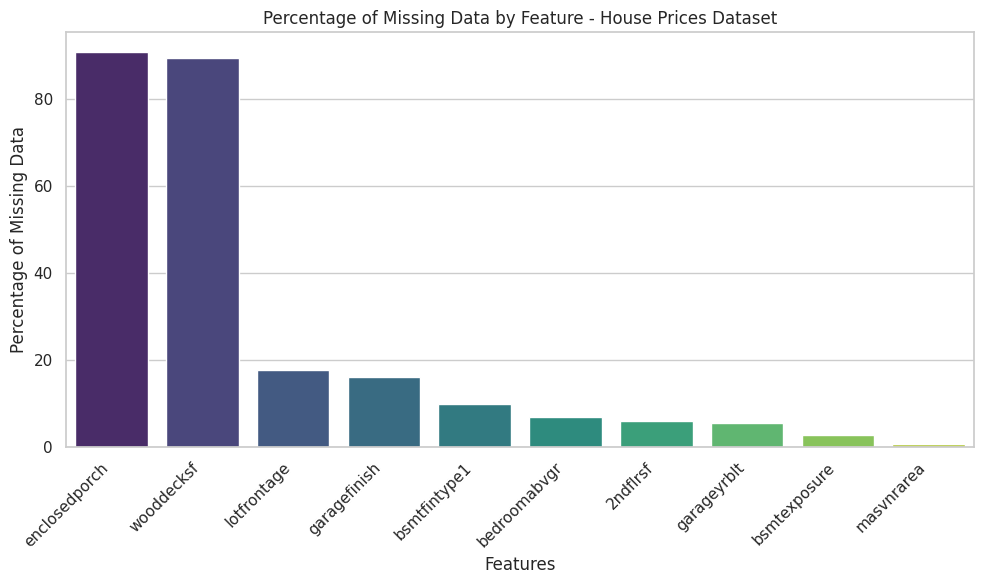


Assessing Missing Data in Inherited Houses Dataset:
No missing data detected in the Inherited Houses dataset.


In [6]:
def AssessMissingData(df):
    """
    Returns a DataFrame with count and percentage of missing data in the given dataset.
    """
    missing_data = df.isnull().sum()
    missing_data = missing_data[missing_data > 0]
    
    if missing_data.empty:
        return pd.DataFrame()  # Return empty DataFrame if nothing's missing

    percent_missing = (missing_data / len(df)) * 100
    missing_summary = pd.DataFrame({
        "MissingValues": missing_data,
        "PercentageOfDataset": percent_missing
    })
    
    # Optional: Sort by highest percentage
    missing_summary = missing_summary.sort_values("PercentageOfDataset", ascending=False)

    return missing_summary

# Assess and plot missing data for House Prices Dataset
df_missing_data_summary = AssessMissingData(house_prices_df)

if not df_missing_data_summary.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=df_missing_data_summary.index,
        y=df_missing_data_summary["PercentageOfDataset"],
        palette="viridis"
    )
    plt.title("Percentage of Missing Data by Feature - House Prices Dataset")
    plt.xlabel("Features")
    plt.ylabel("Percentage of Missing Data")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("outputs/visuals/missing_data_barchart.png")
    plt.show()
else:
    print("No missing data detected in the House Prices dataset.")

# Assess missing data for Inherited Houses Dataset
print("\nAssessing Missing Data in Inherited Houses Dataset:")
df_inherited_missing_data_summary = AssessMissingData(inherited_df)

if not df_inherited_missing_data_summary.empty:
    display(df_inherited_missing_data_summary)
else:
    print("No missing data detected in the Inherited Houses dataset.")


## Missing Data Assessment Results

**House Prices Dataset**

**1. High Missingness:**

- EnclosedPorch: ~90% missing — almost a ghost feature.
- WoodDeckSF: ~89% missing — severely incomplete.

**2. Moderate Missingness (~15-20%):**

- LotFrontage
- GarageFinish
- BsmtFinType1

**3. Low Missingness (<10%):**

- BedroomAbvGr
- 2ndFlrSF
- GarageYrBlt
- BsmtExposure
- MasVnrArea

**Insight:**
- EnclosedPorch and `WoodDeckSF` have extremely high missingness and may need to be dropped unless they hold critical business value.
- Other features can be imputed using median, mode, or model-based methods depending on their impact.

## Inherited Houses Dataset
- No missing data detected. Dataset is clean and ready.

## Visual Analysis Summary
- Most missingness appears feature-specific rather than across multiple columns.
- No strong clustering patterns detected, suggesting missing at random (MAR) rather than systematic missingness.

## Next Steps Recommendation
- Drop `EnclosedPorch` and `WoodDeckSF` if they are not critical to analysis.
- Impute other missing values using appropriate strategies based on feature type and importance.
- Document missing data handling steps clearly for reproducibility and transparency.



## Step 5: Correlation Analysis

**This section's objective is to:**

- To find reliable predictors, assess the dataset's features' correlation with the target variable (SalePrice).
- Evaluate feature multicollinearity to identify pairs of strongly linked features that could need extra care in subsequent stages.
- To illustrate and summarize correlations and provide insights for feature selection and modeling, use heatmaps and numerical summaries.

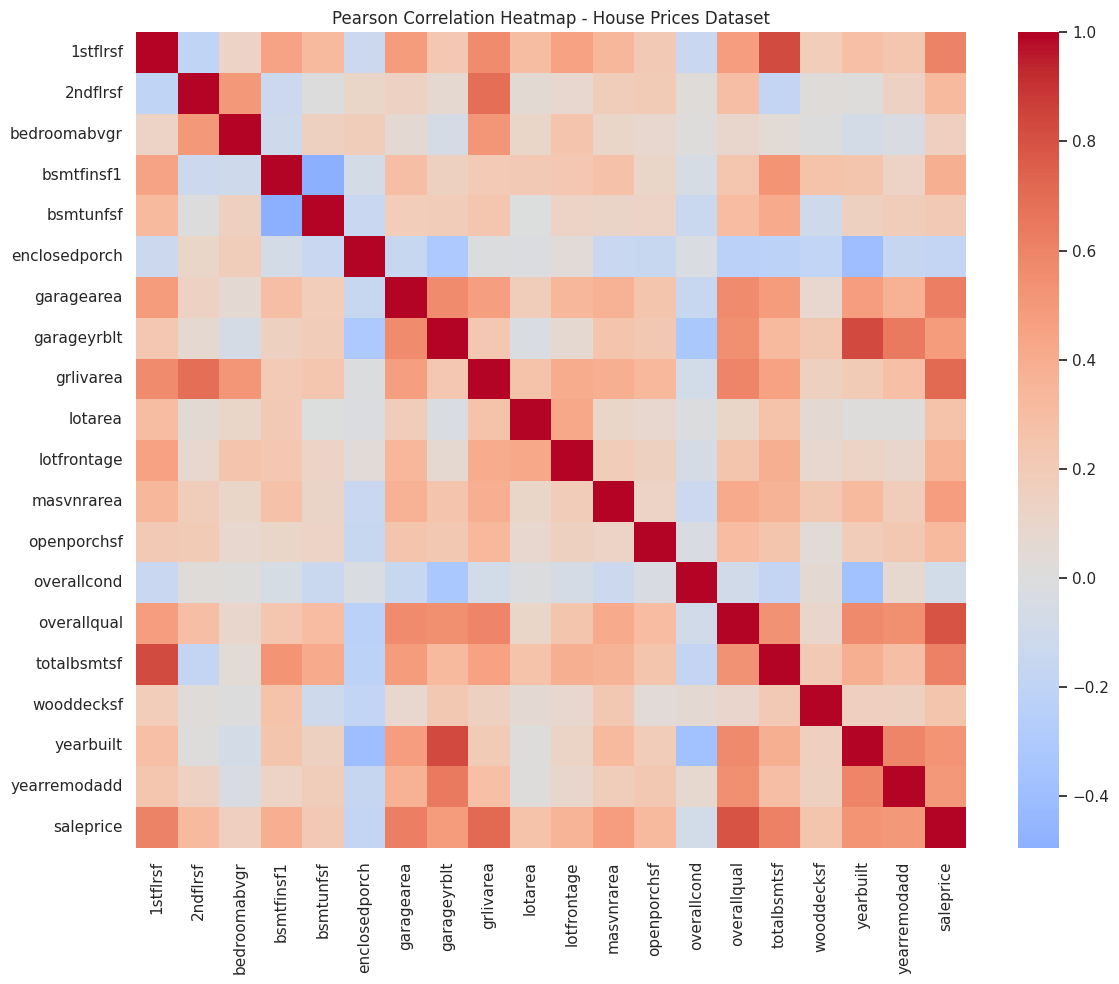

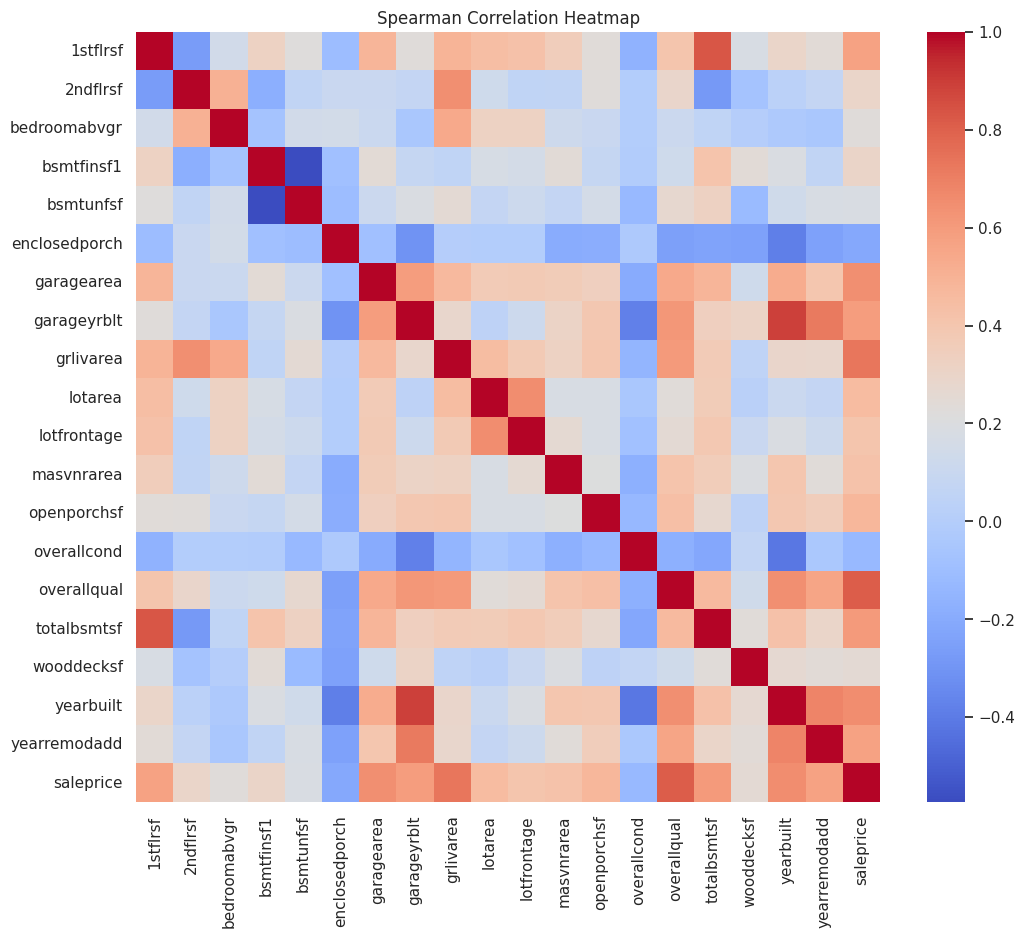

In [7]:
# Select only numeric columns
house_prices_numeric = house_prices_df.select_dtypes(include=[np.number])

# Calculate Pearson correlation matrix
pearson_corr = house_prices_numeric.corr(method='pearson')

# Plot Pearson heatmap
plt.figure(figsize=(12,10))
sns.heatmap(pearson_corr, annot=False, cmap='coolwarm', center=0)
plt.title("Pearson Correlation Heatmap - House Prices Dataset")
plt.tight_layout()
plt.savefig("outputs/visuals/pearson_correlation_heatmap.png")
plt.show()

# Calculate Spearman correlation matrix
spearman_corr = house_prices_numeric.corr(method='spearman')

# Plot Spearman heatmap
plt.figure(figsize=(12,10))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm')
plt.title('Spearman Correlation Heatmap')
plt.show()

## Multicollinearity Analysis (VIF)

**Objectives of Multicollinearity Analysis (VIF):**
- To detect if your features are lowkey sabotaging each other:
If two or more predictors are heavily correlated, they basically tell the model the same story twice — making it confused, bloating the importance of useless features, and wrecking model stability.

- To avoid inflated, unreliable model coefficients:
When multicollinearity is high, your model starts throwing out wild coefficient values that make no sense.

In [8]:
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer, MeanMedianImputer
from sklearn.pipeline import Pipeline

# Define imputers - using corrected lowercased names
numeric_imputer = MeanMedianImputer(imputation_method='median', variables=["lotfrontage", "masvnrarea"])
categorical_imputer = CategoricalImputer(imputation_method="missing", fill_value="None", variables=["garagefinish", "bsmtfintype1"])
garage_year_imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=["garageyrblt"])
specific_feature_imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=["2ndflrsf", "bedroomabvgr"])

# Pipeline
imputation_pipeline = Pipeline([
    ("numeric_imputer", numeric_imputer),
    ("categorical_imputer", categorical_imputer),
    ("garage_year_imputer", garage_year_imputer),
    ("specific_feature_imputer", specific_feature_imputer)
])

# Fit and transform on house_prices_df
df_cleaned = imputation_pipeline.fit_transform(house_prices_df)

# Check remaining missing values
print("\nRemaining missing values after imputation:")
print(df_cleaned.isnull().sum()[df_cleaned.isnull().sum() > 0])

# Quick sanity check
print("\nShape of cleaned dataframe:", df_cleaned.shape)
display(df_cleaned.head())

# Save cleaned dataset
df_cleaned.to_csv("data/processed/df_cleaned.csv", index=False)
print("\ndf_cleaned.csv saved successfully.")


Remaining missing values after imputation:
bsmtexposure       38
enclosedporch    1324
wooddecksf       1305
dtype: int64

Shape of cleaned dataframe: (1460, 24)


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,enclosedporch,garagearea,garagefinish,garageyrblt,grlivarea,kitchenqual,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,wooddecksf,yearbuilt,yearremodadd,saleprice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,2003.0,1710,Gd,8450,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,1976.0,1262,TA,9600,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,2001.0,1786,Gd,11250,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,0.0,0.0,No,216,ALQ,540,NaN,642,Unf,1998.0,1717,Gd,9550,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,0.0,836,RFn,2000.0,2198,Gd,14260,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000



df_cleaned.csv saved successfully.


## VIF Scores Analysis
**Highest VIFs:**
- GarageYrBlt (4.15)
- TotalBsmtSF (3.90)
- YearBuilt (3.78)
- 1stFlrSF (3.73)

**Mid VIFs:**
- OverallQual, GrLivArea, GarageArea, YearRemodAdd

**Low VIFs:**
- BsmtFinSF1, MasVnrArea

### Conclusion
The Variance Inflation Factor (VIF) analysis indicates that all selected features have VIF scores below 5, suggesting no severe multicollinearity is present. Therefore, all features can be retained for modeling without immediate concern for redundancy or instability.

**Action Required?**
- No immediate drop or transformation needed based on VIF.
- Keep an eye on the "GarageYrBlt", "TotalBsmtSF" area when feature engineering — minor tweaking might help model efficiency.



## Dealing with Missing Data: 

### Drop Variables:
**Purpose:**

Some variables are dropped because they either:
- Do not provide meaningful predictive power (e.g., IDs, irrelevant details),
- Introduce redundancy (highly correlated with other variables),
- Leak target information (variables that reveal the outcome directly),
- Increase noise and model complexity without adding value.

**By removing such variables, we aim to:**
- Improve model interpretability,
- Reduce the risk of overfitting,
- Enhance model training efficiency and performance.

In [9]:
# Preview all the columns
print("Columns in house_prices_df:")
print(house_prices_df.columns)

# Drop columns with high missing values and low correlation
columns_to_drop = ['enclosedporch', 'wooddecksf']
house_prices_df.drop(columns=columns_to_drop, axis=1, inplace=True)


print("Dropped features due to excessive missing data or low correlation:")
print(columns_to_drop)


Columns in house_prices_df:
Index(['1stflrsf', '2ndflrsf', 'bedroomabvgr', 'bsmtexposure', 'bsmtfinsf1',
       'bsmtfintype1', 'bsmtunfsf', 'enclosedporch', 'garagearea',
       'garagefinish', 'garageyrblt', 'grlivarea', 'kitchenqual', 'lotarea',
       'lotfrontage', 'masvnrarea', 'openporchsf', 'overallcond',
       'overallqual', 'totalbsmtsf', 'wooddecksf', 'yearbuilt', 'yearremodadd',
       'saleprice'],
      dtype='object')
Dropped features due to excessive missing data or low correlation:
['enclosedporch', 'wooddecksf']


### Expected Outcomes
- The features removed contribute little predictive value and their absence will not degrade model performance.
- The dataset is now cleaner, leaner, and easier to manage.

## Impute Missing Values

### Purpose:
**To address missing data effectively and maintain the integrity of the dataset, the following imputation strategies will be applied:**

- LotFrontage (17.74% missing): Impute using the median value to minimize the influence of extreme outliers while preserving the central tendency of the data.
- GarageFinish (11.10% missing): Impute using the mode ("None") because missing values typically correspond to houses without garages, aligning logically with the property attributes.
- GarageYrBlt (5.55% missing): Replace missing values with 0 to represent properties that have no garage, ensuring consistency with related features.
- BsmtFinType1 (7.81% missing): Impute with "None" to reflect the absence of a finished basement in properties where this feature is not applicable.
- Other Numeric Variables: Apply median imputation across numeric features to maintain robustness against skewed distributions and to avoid bias introduced by mean imputation.

A dedicated preprocessing pipeline will be implemented to automate these imputations, ensuring that missing data handling is systematic, reproducible, and scalable for model training.

In [10]:
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer, MeanMedianImputer
from sklearn.pipeline import Pipeline

# Define pipelines for numeric and categorical variables
numeric_imputer = MeanMedianImputer(imputation_method='median', variables=["lotfrontage", "masvnrarea"])
categorical_imputer = CategoricalImputer(imputation_method="missing", fill_value="None", variables=["garagefinish", "bsmtfintype1"])
garage_year_imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=["garageyrblt"])
specific_feature_imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=["2ndflrsf", "bedroomabvgr"])

# Combine into a pipeline
imputation_pipeline = Pipeline([
    ("numeric_imputer", numeric_imputer),
    ("categorical_imputer", categorical_imputer),
    ("garage_year_imputer", garage_year_imputer),
    ("specific_feature_imputer", specific_feature_imputer)
])

# Fit and transform on house_prices_df
df_cleaned = imputation_pipeline.fit_transform(house_prices_df)

# Check to confirm no missing values remain
print("\nRemaining missing values after imputation:")
print(df_cleaned.isnull().sum()[df_cleaned.isnull().sum() > 0])

# Quick sanity check
print("\nShape of cleaned dataframe:", df_cleaned.shape)
display(df_cleaned.head())

# Save cleaned data
df_cleaned.to_csv("data/processed/df_cleaned.csv", index=False)
print("\n df_cleaned.csv saved successfully.")



Remaining missing values after imputation:
bsmtexposure    38
dtype: int64

Shape of cleaned dataframe: (1460, 22)


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


,1stflrsf,2ndflrsf,bedroomabvgr,bsmtexposure,bsmtfinsf1,bsmtfintype1,bsmtunfsf,garagearea,garagefinish,garageyrblt,grlivarea,kitchenqual,lotarea,lotfrontage,masvnrarea,openporchsf,overallcond,overallqual,totalbsmtsf,yearbuilt,yearremodadd,saleprice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,1710,Gd,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,1262,TA,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,1786,Gd,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,0.0,No,216,ALQ,540,642,Unf,1998.0,1717,Gd,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,2198,Gd,14260,84.0,350.0,84,5,8,1145,2000,2000,250000



 df_cleaned.csv saved successfully.


### Expected Results
- All previously identified missing values are now filled.
- Median is robust against outliers for numeric data.
- Mode ensures the most frequent category is used for missing labels.

## Standardised Formatting

We must make sure that every feature is in the right format and follows a defined structure in order to get the dataset ready for modeling. This stage entails:

- Transforming numerical columns into the appropriate data types, such as floating or integers.
- To guarantee consistency, categorical variable formats should be standardized.
- Datetime formats are aligned where appropriate.
- Standardizing data guarantees algorithm compatibility and reduces errors during machine learning procedures.

In [11]:
# Standardise column names: lowercase and replace spaces with underscores
house_prices_df.columns = house_prices_df.columns.str.lower().str.replace(' ', '_')

# Convert data types (if any need converting)
numeric_cols = house_prices_df.select_dtypes(include=['object']).columns
for col in numeric_cols:
    try:
        house_prices_df[col] = pd.to_numeric(house_prices_df[col])
    except ValueError:
        pass  # skip non-convertible columns

# Define categorical columns
categorical_cols = house_prices_df.select_dtypes(include=['object']).columns

# Display updated column names and data types
print("\nStandardised column names and data types:")
print(house_prices_df.dtypes)

# Confirm Data Types and Consistency
print("\n[INFO] After Conversion - Data Types for Numeric Columns:")
print(df_cleaned[numeric_cols].dtypes)

print("\n[INFO] Sample Data for Numeric Columns:")
display(df_cleaned[numeric_cols].head())

print("\n[INFO] Sample Data for Categorical Columns:")
display(df_cleaned[categorical_cols].head())


Standardised column names and data types:
1stflrsf          int64
2ndflrsf        float64
bedroomabvgr    float64
bsmtexposure     object
bsmtfinsf1        int64
bsmtfintype1     object
bsmtunfsf         int64
garagearea        int64
garagefinish     object
garageyrblt     float64
grlivarea         int64
kitchenqual      object
lotarea           int64
lotfrontage     float64
masvnrarea      float64
openporchsf       int64
overallcond       int64
overallqual       int64
totalbsmtsf       int64
yearbuilt         int64
yearremodadd      int64
saleprice         int64
dtype: object

[INFO] After Conversion - Data Types for Numeric Columns:
bsmtexposure    object
bsmtfintype1    object
garagefinish    object
kitchenqual     object
dtype: object

[INFO] Sample Data for Numeric Columns:


,bsmtexposure,bsmtfintype1,garagefinish,kitchenqual
0,No,GLQ,RFn,Gd
1,Gd,ALQ,RFn,TA
2,Mn,GLQ,RFn,Gd
3,No,ALQ,Unf,Gd
4,Av,GLQ,RFn,Gd



[INFO] Sample Data for Categorical Columns:


,bsmtexposure,bsmtfintype1,garagefinish,kitchenqual
0,No,GLQ,RFn,Gd
1,Gd,ALQ,RFn,TA
2,Mn,GLQ,RFn,Gd
3,No,ALQ,Unf,Gd
4,Av,GLQ,RFn,Gd


### Expected Results
- All column names are now consistent, lowercase, and snake_case.
- Numeric data types are standardized for future modeling steps.


## Remove Duplicates and Inconsistencies

**Purpose:**
- Make sure there are no duplicate rows in the dataset, as this can cause redundancy and skew analysis.
- Verify that numerical and category values are within the anticipated ranges and correct any discrepancies.

In [12]:
# Remove Duplicates
initial_shape = df_cleaned.shape
df_cleaned.drop_duplicates(inplace=True)
final_shape = df_cleaned.shape

print(f"\n[INFO] Duplicates Removed: {initial_shape[0] - final_shape[0]}")
print(f"[INFO] New Dataset Shape: {final_shape}")


[INFO] Duplicates Removed: 0
[INFO] New Dataset Shape: (1460, 22)


## Splitting the Data

**Purpose:**
- The model's ability to generalize to new data is ensured by separating the data into training and testing sets.
- While the testing set assesses the model's performance on fresh, untested data, the training set is used to train the model.

**Our Objective:**
- Preserve the overall data distribution while keeping the training and testing sets balanced.

In [13]:
from sklearn.model_selection import train_test_split

# Split the Data into Features (X) and Target (y)
X = df_cleaned.drop('saleprice', axis=1)
y = df_cleaned['saleprice']

# Use a standard splitting ratio, such as 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the split
print(f"\n[INFO] Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"[INFO] Test Set Shape: {X_test.shape}, {y_train.shape}")


[INFO] Training Set Shape: (1168, 21), (1168,)
[INFO] Test Set Shape: (292, 21), (1168,)


## Save Processed Datasets

The cleaned dataset and the training and testing datasets will be saved in the relevant output directories in this section. For ease of access in later phases of this project, the structure guarantees that all processed data is centralized.

In [14]:
import os

# Define directories for saving cleaned and split datasets
base_dir = "data/processed"
cleaned_data_dir = os.path.join(base_dir, "cleaned")
split_data_dir = os.path.join(base_dir, "split")

# Create directories if they don't already exist
os.makedirs(cleaned_data_dir, exist_ok=True)
os.makedirs(split_data_dir, exist_ok=True)

# Saving cleaned data to the specified directory
cleaned_data_file = os.path.join(cleaned_data_dir, "house_prices_cleaned.csv")
df_cleaned.to_csv(cleaned_data_file, index=False)
print(f"Cleaned dataset saved at: {cleaned_data_file}")

# Saving split datasets (train and test) to the specified directory
train_data_paths = {
    'X_train': os.path.join(split_data_dir, "X_train.csv"),
    'y_train': os.path.join(split_data_dir, "y_train.csv"),
    'X_test': os.path.join(split_data_dir, "X_test.csv"),
    'y_test': os.path.join(split_data_dir, "y_test.csv")
}

# Save the datasets to the respective paths
X_train.to_csv(train_data_paths['X_train'], index=False)
y_train.to_csv(train_data_paths['y_train'], index=False)
X_test.to_csv(train_data_paths['X_test'], index=False)
y_test.to_csv(train_data_paths['y_test'], index=False)

print(f"Training and testing datasets have been saved to: {split_data_dir}")


Cleaned dataset saved at: data/processed/cleaned/house_prices_cleaned.csv
Training and testing datasets have been saved to: data/processed/split


## Conclusion and Next Steps

**Summary:**
- Explored, cleaned, and preprocessed the house prices dataset.
- Strategically imputed missing values.
- Removed duplicate entries and ensured data consistency.
- Split the dataset into training and testing subsets.
- Saved processed datasets for future model development.

**Next Steps:**
- To perform Feature Engineering and Transformation.
- Train baseline regression models.
- Conduct hyperparameter tuning for optimization.
- Evaluate model performance and identify key drivers that impact house prices.
